# Industry Accelerators - Financial Markets Customer Segmentation Model

## Introduction

In this notebook we will do some customer segmentation work. Segmentation can help you to identify and understand customer subgroups and how they differ from one another. Customer segmentation has many beneficial uses. In our case for example, it can be used to assign the best-fit agent, identify opportunities for leveraging agent skills, or even to create hosting opportunities to improve client engagement.<br><br>
We'll prepare the data so it's in a wide format ready for segmentation and then apply some transformation and clustering techniques. Our data contains demographic, behavioral, summary product and communication based data. Since there are currently no predefined segments we'll need to discover segments within the underlying data structure. Once that structure is found we'll assign clients to their respective clusters and surface that information through the user interface.


Before executing this notebook on IBM Cloud, you need to:<br>
1) When you import this project on an IBM Cloud environment, a project access token should be inserted at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) Provide your IBM Cloud API key in the subsequent cell<br>
3) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>


#### Insert IBM Cloud API key
Your Cloud API key can be generated by going to the [API Keys section of the Cloud console](https://cloud.ibm.com/iam/apikeys). From that page, scroll down to the API Keys section, and click Create an IBM Cloud API key. Give your key a name and click Create, then copy the created key and paste it below. 

If you are running this notebook on cloud pak for data on-prem, leave the ibmcloud_api_key field blank.

In [34]:
ibmcloud_api_key = ''

In [35]:
try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project() 

In the cell below we import the python libraries that we will use throughout the notebook.

In [36]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import importlib
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys
import joblib
import seaborn as sns
import time 
from sklearn.preprocessing import StandardScaler
import pickle 

warnings.filterwarnings('ignore')

np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

### Load Customer Segmentation Prepped Data

Read the data that was prepared in the previous notebook

In [37]:
prepped_data_file = project.get_file("training_data.csv")
prepped_data_file.seek(0)

df_prepped = pd.read_csv(prepped_data_file)                    

### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original categorical features.

In [38]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)

# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre_transform = df_prepped.copy()

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Standardize Data

The last step for our data preparation is to standardize the numeric variables. Standardizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [39]:
scale_features = df_prepped[numeric_cols]

scaler = StandardScaler()
scale_features = scaler.fit_transform(scale_features.values)
df_prepped[numeric_cols] = scale_features

# store the columns to be standardised, means and standard deviations in the training metadata 
with open('training_data_metadata.json', 'r') as f:
    training_metadata = json.load(f)

training_metadata['cols_to_standardise'] = numeric_cols
training_metadata['scaler_means'] = list(scaler.mean_)
training_metadata['scaler_standard_dev'] = list(np.sqrt(scaler.var_))

# store the names of the columns used for training
training_metadata['cols_used_for_training'] = list(df_prepped.columns)

with open('training_data_metadata.json', 'w') as f:
    json.dump(training_metadata, f)

In [40]:
# Preview prepped data with standardized numeric values
df_prepped.head()

,CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES,CUSTOMER_ANNUAL_INCOME,CUSTOMER_TENURE_IN_MONTHS,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Giving,CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Health,CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Housing,CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Insurance,...,CUSTOMER_IMPORTANCE_LEVEL_CODE_Low priority,CUSTOMER_IMPORTANCE_LEVEL_CODE_Normal priority,CUSTOMER_PURSUIT_Education Planning,CUSTOMER_PURSUIT_Estate Planning,CUSTOMER_PURSUIT_Increase Net Worth,CUSTOMER_PURSUIT_Philanthropy,CUSTOMER_PURSUIT_Retirement Planning,CUSTOMER_CUSTOMER_BEHAVIOR_Conserviti,CUSTOMER_CUSTOMER_BEHAVIOR_Growth,CUSTOMER_CUSTOMER_BEHAVIOR_Moderate
0,-0.850833,0.932255,-0.897529,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2.167705,0.573600,-0.701125,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,-0.950851,-0.621916,-0.406519,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,-0.959148,-0.701617,-0.897529,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,1.517783,1.131508,-0.897529,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


## Plot Functions

Here is a plotting function with an example to view the distribution of any feature within the dataset.

In [41]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


This function plots the distribution of categorical variables by each cluster.

In [42]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform):
    df_temp = prepped_data_pre_transform.groupby(['CLUSTERS', cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index='CLUSTERS', columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index('CLUSTERS').plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return

This function plots the distribution of numerical variables by each cluster.

In [43]:
def plot_numeric_vars(var, prepped_data_pre_transform, num_clusters):
    
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in range(0, num_clusters + 1):
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS'] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## Principal Component Analysis (PCA)

Now that our data is clean, with some transformations we're going to do one last transformation. We'll use principal components analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

Below we perform PCA on our dataset and select 14 components. You can see the newly transformed and reduced data set below. This will be the data set that we pass to our clustering algorithm.

In [44]:
# PCA
pca = PCA(n_components=14)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.633069,0.313649,-0.425015,0.899855,-0.658680,1.346514,0.145216,0.203657,-0.129300,-0.039003,0.130812,0.134386,-0.081034,-0.265363
1,2.412770,1.449158,-1.563411,0.826072,-0.414704,-0.496566,0.013728,0.963548,-0.196857,0.225845,-0.688783,-0.154865,0.177898,0.054459
2,0.275778,-0.993911,1.886191,0.385648,0.002759,0.249279,0.753733,0.430161,0.489987,0.696977,-0.194755,-0.642770,-0.126248,-0.246411
3,0.530589,-1.085195,1.672390,0.855310,-0.271357,0.266503,0.281010,-0.008483,0.418990,0.740639,-0.531212,-0.803818,-0.147092,-0.654761
4,-0.680556,1.766475,-1.074686,1.096721,1.025808,0.680434,-0.147270,-0.195357,0.256344,0.173297,-0.220070,0.445375,0.017523,0.358103


From our PCA, we can view how much variance is explained for each additional principal component. The below cumulative sum shows that the first 14 components explains 90.6% of the data.

In [45]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.21764406 0.38447951 0.52871062 0.64044143 0.70645547 0.74986159
 0.78734266 0.81547565 0.83739013 0.8552912  0.87230688 0.88615576
 0.89701815 0.9068444 ]


Below we save our PCA model for later scoring.

In [46]:
# Save out PCA
# mimetype is guessed when promoting the asset into the deployment space
# we need to save the file as a type recognised by the mimetype library
# this doesn't impact the object type
joblib.dump(pca, 'pca.txt')

['pca.txt']

## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called silhouette coefficient. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

In [47]:
# Specify max number of clusters for iteration
max_number_of_clusters = 15

# Loop through K-means and view silhouette coefficient to determine number of clusters
for i in range(2, max_number_of_clusters+1):
    kmeans_mdl = KMeans(n_clusters=i, random_state=1234)
    #kmeans_mdl.fit(df_pca)
    kmeans_mdl.fit(df_prepped)
    labels = kmeans_mdl.labels_
    silhouette_coef = metrics.silhouette_score(df_pca, labels, metric='euclidean')
    print('Silhouette coefficient for ' + str(i) + ' clusters:' + str(silhouette_coef))

Silhouette coefficient for 2 clusters:0.224305883685827
Silhouette coefficient for 3 clusters:0.23194492483678308
Silhouette coefficient for 4 clusters:0.27508301942871627
Silhouette coefficient for 5 clusters:0.286397381067411
Silhouette coefficient for 6 clusters:0.2788823619138453
Silhouette coefficient for 7 clusters:0.2941961659912486
Silhouette coefficient for 8 clusters:0.28387204674493355
Silhouette coefficient for 9 clusters:0.2664567801325143
Silhouette coefficient for 10 clusters:0.2635051410789128
Silhouette coefficient for 11 clusters:0.26770485375848013
Silhouette coefficient for 12 clusters:0.25486505762415457
Silhouette coefficient for 13 clusters:0.25978981891916536
Silhouette coefficient for 14 clusters:0.2594041824836951
Silhouette coefficient for 15 clusters:0.24569946897498887


For the above exercise we see that number of clusters should be 6 or 7 based on the silhouette coefficient. For this exercise we selected 7 clusters.

We then fit the k-means algorithm to our data using the specified 7 clusters. Then we add those cluster assignments back to the PCA dataframe so we can visualize the cluster assignments on a 2-dimensional plot.

In [48]:
# K-means with 7 clusters based on silhouette coefficient
num_clusters = 7
kmeans_mdl = KMeans(n_clusters=num_clusters, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_pca)

In [49]:
# Create dataframe with PCA and cluster assignments
# increment the cluster number by 1 so that cluster numbers start at 1 instead of 0
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12','pc_13','pc_14'])
df_pca_clusters['cluster_id'] = pc_clusters + 1
df_pca_clusters.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,cluster_id
0,-1.633069,0.313649,-0.425015,0.899855,-0.658680,1.346514,0.145216,0.203657,-0.129300,-0.039003,0.130812,0.134386,-0.081034,-0.265363,6
1,2.412770,1.449158,-1.563411,0.826072,-0.414704,-0.496566,0.013728,0.963548,-0.196857,0.225845,-0.688783,-0.154865,0.177898,0.054459,1
2,0.275778,-0.993911,1.886191,0.385648,0.002759,0.249279,0.753733,0.430161,0.489987,0.696977,-0.194755,-0.642770,-0.126248,-0.246411,5
3,0.530589,-1.085195,1.672390,0.855310,-0.271357,0.266503,0.281010,-0.008483,0.418990,0.740639,-0.531212,-0.803818,-0.147092,-0.654761,5
4,-0.680556,1.766475,-1.074686,1.096721,1.025808,0.680434,-0.147270,-0.195357,0.256344,0.173297,-0.220070,0.445375,0.017523,0.358103,7


## Visualize Clusters

To see the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

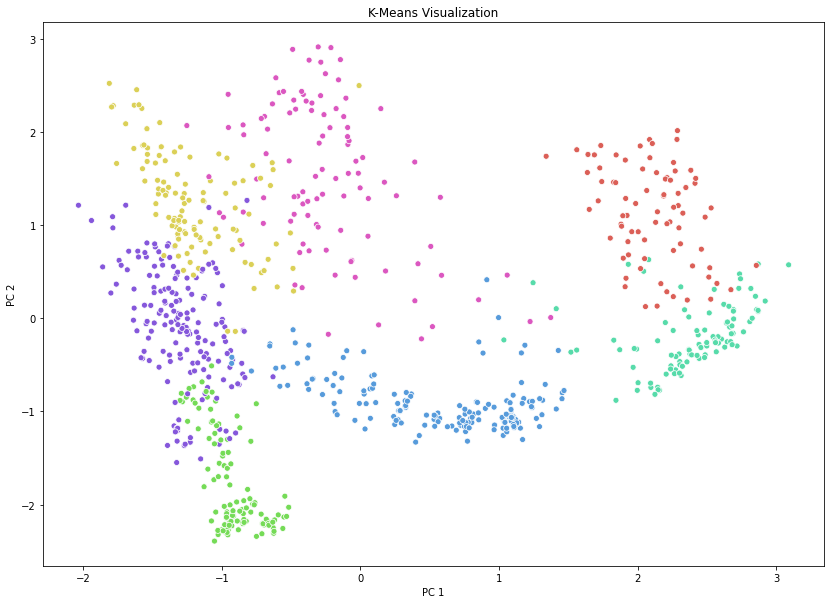

In [50]:
# Plot k-means results with cluster assignments
plt.figure(figsize=(14,10))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", num_clusters)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-Means Visualization");

Before we save the model, we append the clusters to the original prepped dataframe, before we scaled and created dummy variables. We save this dataframe out so that it can be used in the R Shiny dashboard.

In [51]:
prepped_data_pre_transform['CLUSTERS'] = kmeans_mdl.labels_
# increment cluster numbers by 1 so we start at 1 instead of 0
prepped_data_pre_transform['CLUSTERS'] = prepped_data_pre_transform['CLUSTERS'] + 1

# save data for dynamic dashboard
project.save_data("cluster_df.csv", prepped_data_pre_transform.to_csv(index=False), overwrite=True)

prepped_data_pre_transform.head()

,CUSTOMER_MARKET_GROUP,CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY,CUSTOMER_URBAN_CODE,CUSTOMER_EMPLOYMENT_STATUS,CUSTOMER_CREDIT_AUTHORITY_LEVEL,CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES,CUSTOMER_GENDER,CUSTOMER_AGE_RANGE,CUSTOMER_EDUCATION_LEVEL,CUSTOMER_MARITAL_STATUS,CUSTOMER_IMPORTANCE_LEVEL_CODE,CUSTOMER_PURSUIT,CUSTOMER_ANNUAL_INCOME,CUSTOMER_CUSTOMER_BEHAVIOR,CUSTOMER_TENURE_IN_MONTHS,CLUSTERS
0,Accumulating,Recreation,City,Employed,Medium,1757.13,Male,30 to 40,College,Married,Low priority,Capital Acquisition,325000.0,Moderate,8,6
1,Gifting,Uncategorized,Urban,Selfemployed,Very High,17935.79,Female,65 and over,Professional,Divorced,Normal priority,Retirement Planning,280000.0,Aggressive,10,1
2,Accumulating,Travel,Urban,Homemaker,Very Low,1221.06,Female,55 to 65,PhD,Married,High priority,Increase Net Worth,130000.0,Growth,13,5
3,Accumulating,Travel,Urban,Homemaker,Very Low,1176.59,Female,65 and over,PhD,Married,High priority,Increase Net Worth,120000.0,Growth,8,5
4,Accumulating,Food,City,Employed,Medium,14452.36,Male,40 to 55,College,Married,Low priority,Estate Planning,350000.0,Moderate,8,7


### Save the model to Cloud Pak for Data

In the next steps we save and deploy the kmeans model.

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

**If you do not have space already created, you can use Deployment Spaces Dashboard to create one**

- Navigate to Deployments
- Click New Deployment Space
- Enter Deployment space name
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy space name and paste it below 


The steps involved in saving and deploying the model are detailed in the following cells.  We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.

### User Inputs
The user can specify the name for the space, model and model deployment.  <br>


In [52]:
# Specify a name for the space being created, the saved models and the model deployments

space_name = 'Customer Segmentation Space'
model_name = 'customer_segmentation_model'
deployment_name = 'customer_segmentation_model_deployment'

Below code imports `ibm_watson_machine_learning` library and then creates a wml client using the credentials provided.

In [53]:
from ibm_watson_machine_learning import APIClient
import os

if ibmcloud_api_key != '':
    wml_credentials = {
        "apikey": ibmcloud_api_key,
        "url": 'https://' + os.environ['RUNTIME_ENV_REGION'] + '.ml.cloud.ibm.com'
    }
else:
    token = os.environ['USER_ACCESS_TOKEN']
    wml_credentials = {
        "token": token,
        "instance_id" : "openshift",
        "url": os.environ['RUNTIME_ENV_APSX_URL'],
        "version": "3.5"
     }
client = APIClient(wml_credentials)

### Select the Deployment Space

By default, if the space name already exists, the existing space will be used to store and deploy models and functions.

In [54]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with",space_name,"exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        print("Using the existing space")
            
            
if space_uid=="":
    if ibmcloud_api_key == '':
        # create the space and set it as default
        space_meta_data = {
            client.spaces.ConfigurationMetaNames.NAME : space_name

            }

        stored_space_details = client.spaces.store(space_meta_data)

        space_uid = stored_space_details['metadata']['id']

        client.set.default_space(space_uid)
    
    else:
        print("Deployment space",space_name, "doesn't exist, Please create a new deployment space before continue..")
        raise Exception("Deployment space doesn't exist")

Deployment space with Customer Segmentation Space exists . .
Using the existing space


### Store the Model Details

Store the model in the deployment space. Again, the name for the model is specified in the user inputs cell above. Software specification and default tag for the model are specified in the model metadata. <br>
Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()` <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [55]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid,
    client.repository.ModelMetaNames.TAGS: ['customer_segmentation_model_tag'],

}

stored_model_details = client.repository.store_model(model=kmeans_mdl, meta_props=metadata)
stored_model_details

{'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2021-04-13T15:15:04.448Z',
  'id': 'ad7f270e-a4f6-4498-aa1f-882b2e74b153',
  'modified_at': '2021-04-13T15:15:06.601Z',
  'name': 'customer_segmentation_model',
  'owner': 'IBMid-664001TADX',
  'space_id': '8b134edd-9809-4e60-94ff-cca6afc7789f',
  'tags': ['customer_segmentation_model_tag']},
 'system': {'warnings': []}}

### Deploy the Model 

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

In [56]:
# deploy the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['customer_segmentation_deployment_tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.DESCRIPTION:"Customer Segmentation model help you to identify and understand customer subgroups and how they differ from one another by clustering them based on dynamic features"
}

model_uid = stored_model_details["metadata"]["id"]
client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'ad7f270e-a4f6-4498-aa1f-882b2e74b153' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='504ec2f9-5ebc-44ef-ab66-73fc19e2eeff'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': 'ad7f270e-a4f6-4498-aa1f-882b2e74b153'},
  'custom': {},
  'deployed_asset_type': 'model',
  'description': 'Customer Segmentation model help you to identify and understand customer subgroups and how they differ from one another by clustering them based on dynamic features',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
  'name': 'customer_segmentation_model_deployment',
  'online': {},
  'space_id': '8b134edd-9809-4e60-94ff-cca6afc7789f',
  'status': {'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/504ec2f9-5ebc-44ef-ab66-73fc19e2eeff/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2021-04-13T15:15:10.956Z',
  'description': 'Customer Segmentation model help you to identify and understand customer subgroups and how they differ from one another by clustering them based on dynamic features',
  'id': '504ec2f9-5ebc-44ef-ab66-73fc19e2eeff',
  'modified_at': '2021-04-13T15:15:10.956Z',
  '

## Plot Variable Distribution by Cluster

The below code loops through each categorical variable and plots the distribution of each variable by cluster, followed by doing the same for numerical variables. 

Taking the example of Cluster 7, we see that the majority of customers are homemakers or retired. Their primary pursuit is increasing net worth and they exhibit aggressive customer behaviour. All of the customers in this cluster are female, 55 or over, highly educated and urban living. Their annual income is mid-range while they are on the higher end for the amount they pay in fees.

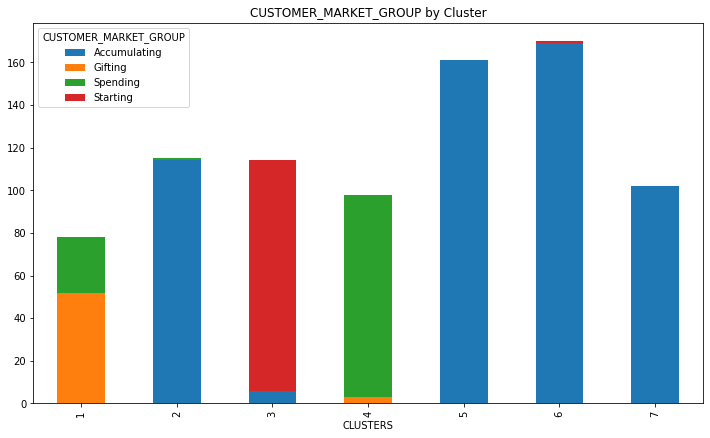

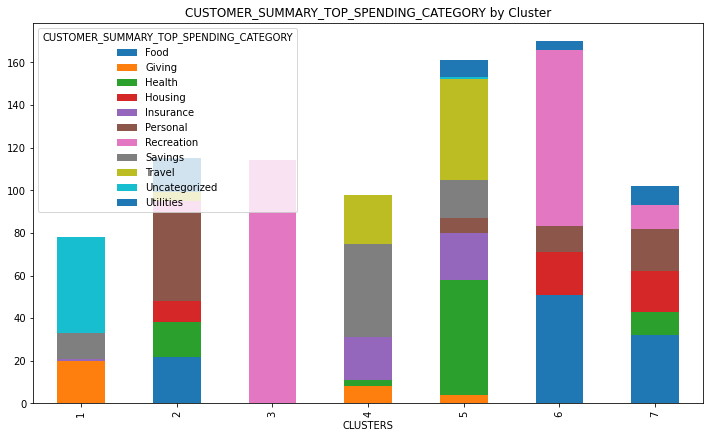

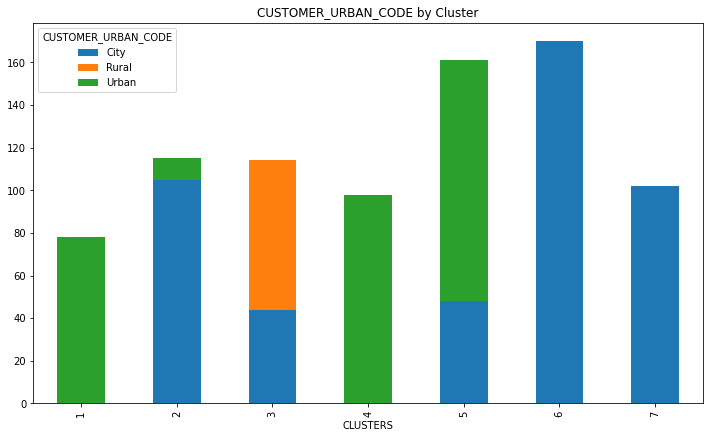

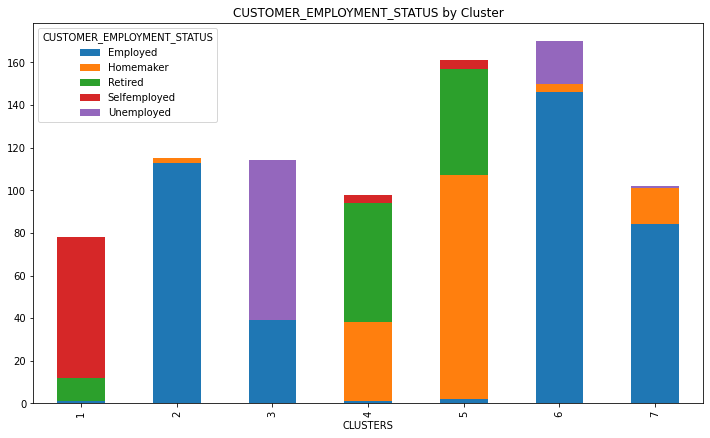

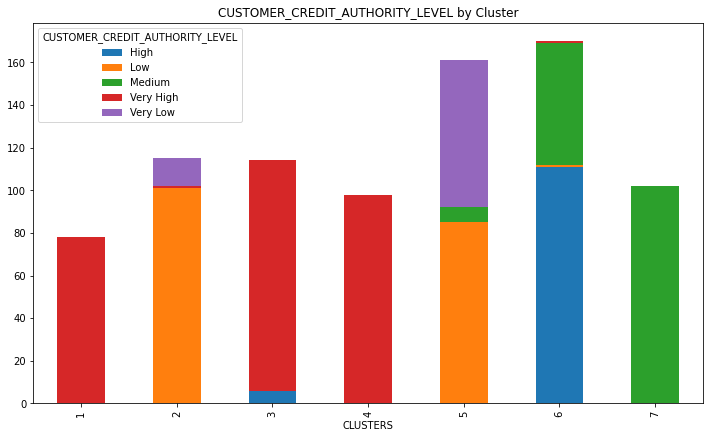

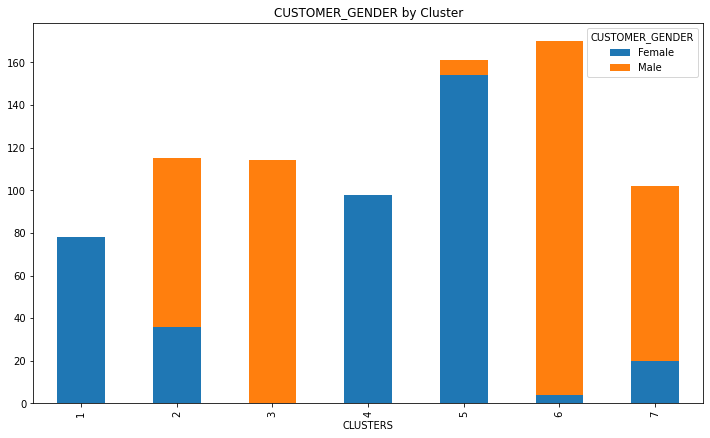

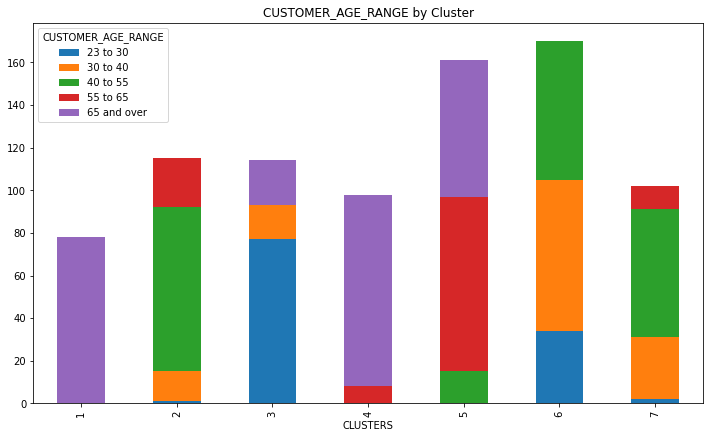

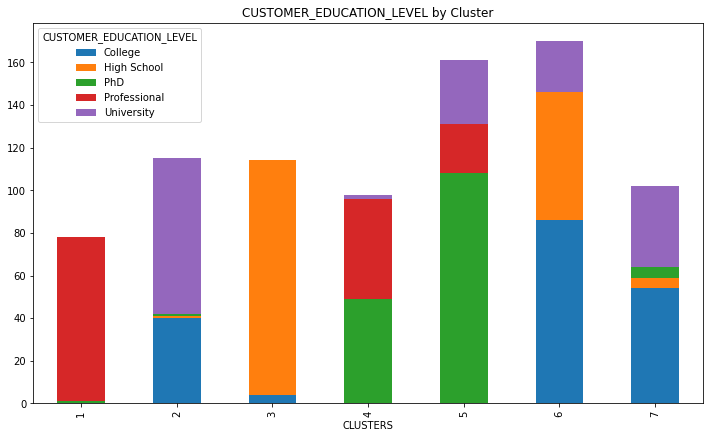

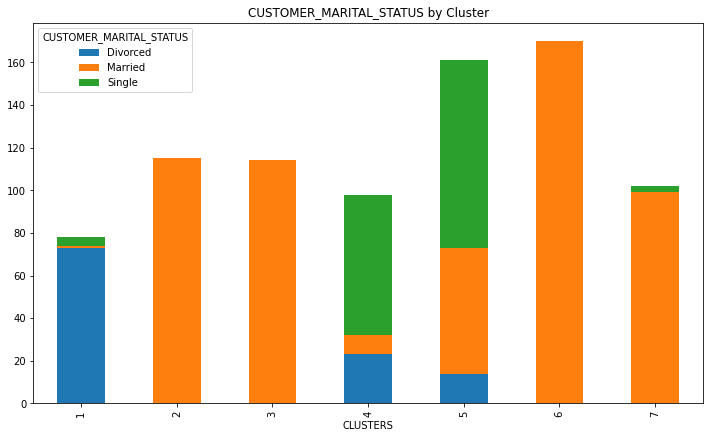

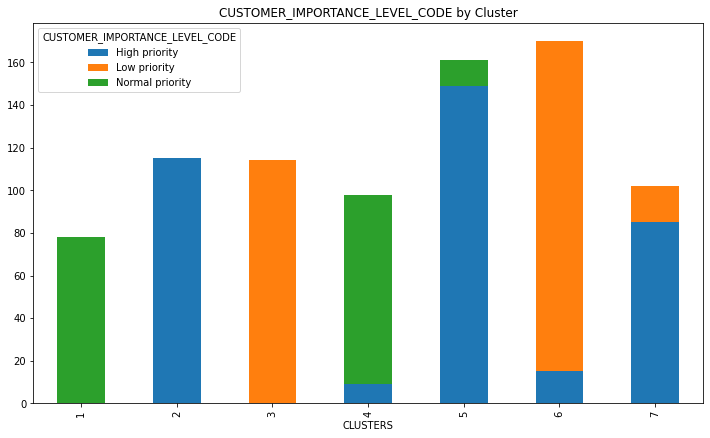

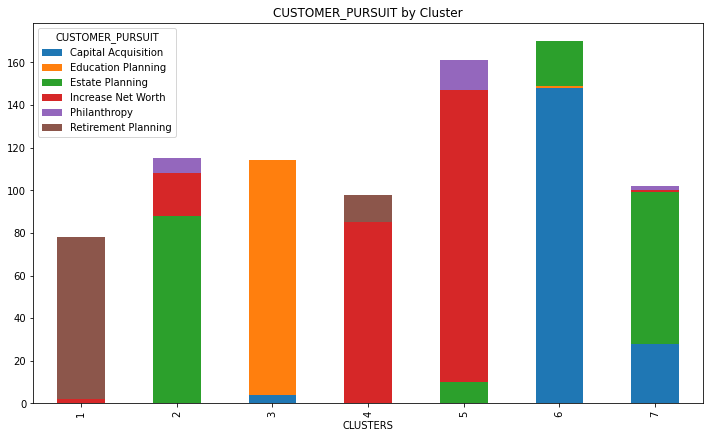

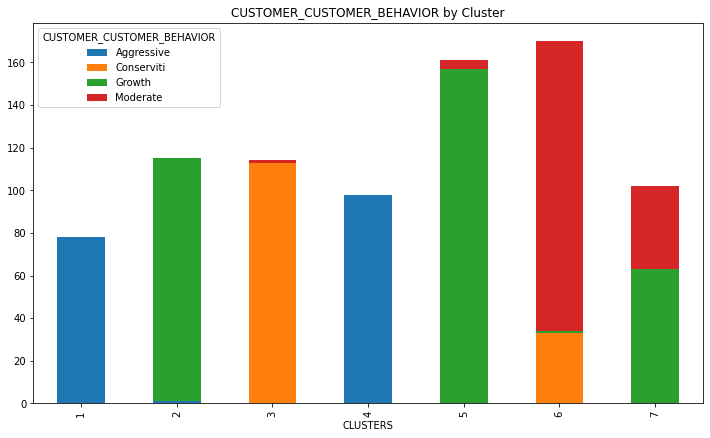

In [57]:
for var in categorical_cols:
    plot_categorical_vars(var, prepped_data_pre_transform)

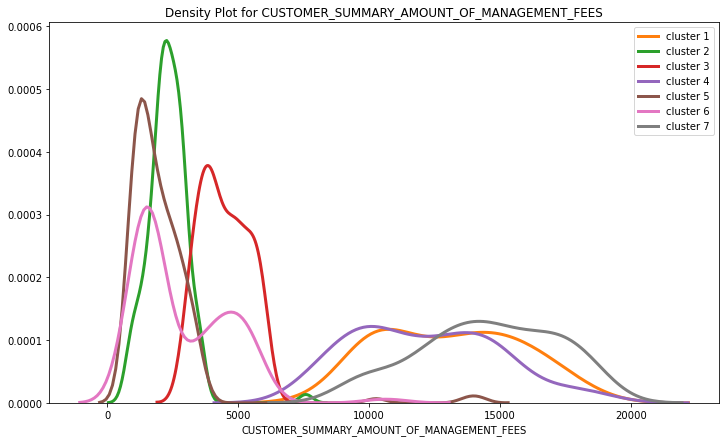

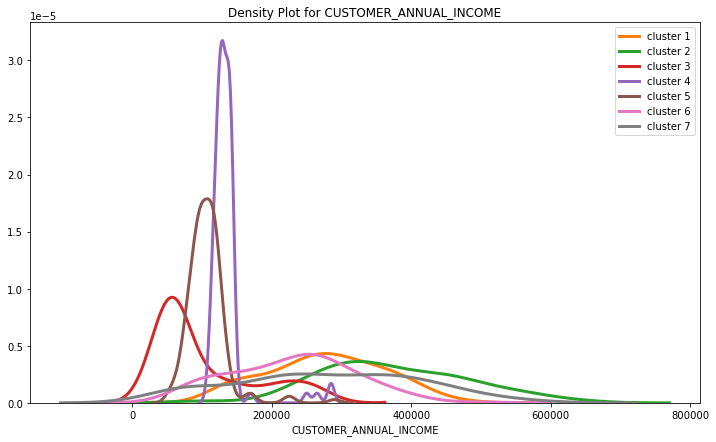

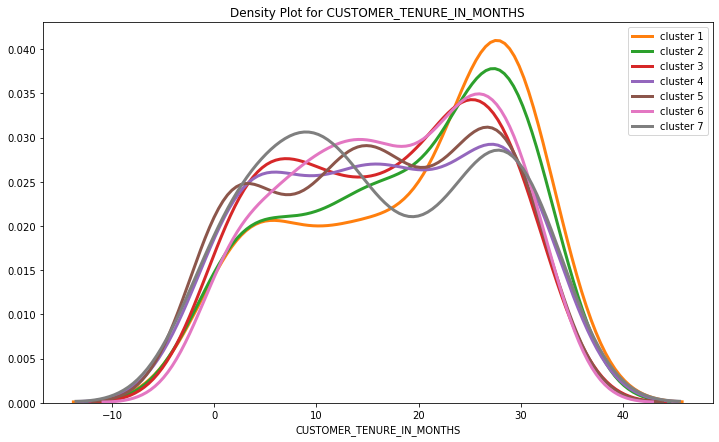

In [58]:
for col in numeric_cols:
    plot_numeric_vars(col, prepped_data_pre_transform, num_clusters)

### Operationalize the models

Now we are ready to operationalize our best model. See notebook **`3-model-scoring`** for the next step.

<hr>
This project contains Sample Materials, provided under this <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license</a>. <br/>
Licensed Materials - Property of IBM. <br/>
© Copyright IBM Corp. 2019, 2020, 2021. All Rights Reserved. <br/>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br/>